# RNN
* The following articles were referenced in the implementation of this notebook
* https://qiita.com/sasayabaku/items/b7872a3b8acc7d6261bf

In [69]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

(500,)


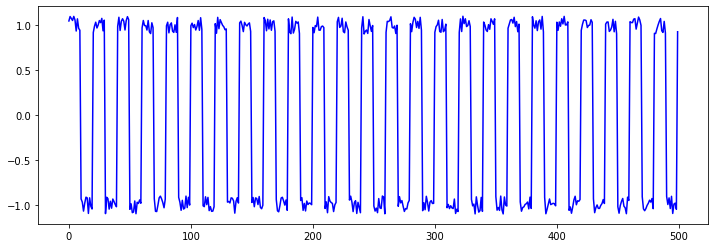

In [70]:
def generate_square_wave(x, T=25):
    return signal.square(2.0 * np.pi * x * T)

def toy_problem(ampl=0.1):
    x = np.linspace(0, 1, 500)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return generate_square_wave(x) + noise

f = toy_problem()
print(np.shape(f))

plt.figure(figsize=(12, 4))
plt.plot(range(0, len(f)), f, color="b")
plt.show()

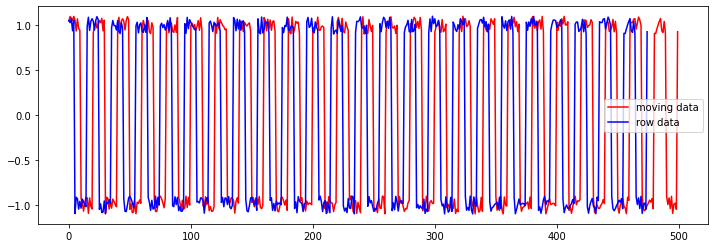

In [71]:
# f(0), f(1), f(2), f(3), f(4) -> label(1)
# f(1), f(2), f(3), f(4), f(5) -> label(2)
# f(2), f(3), f(4), f(5), f(6) -> label(2)
def make_dataset(low_data):
    data, target = [], []
    maxlen = 25

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen]) # (95, 5)
        target.append(low_data[i + maxlen]) # (95)

    re_data = np.array(data).reshape(len(data), maxlen, 1) # (95, 5, 1)
    re_target = np.array(target).reshape(len(data), 1) # (95, 1)

    return re_data, re_target 

g, h = make_dataset(f)  # g: train_data, h: train_label

plt.figure(figsize=(12, 4))
plt.plot(range(0, len(f)), f, color="r", label="moving data")
plt.plot(range(0, len(h)), h, color="b", label="row data")
plt.legend()
plt.show()

In [72]:
# make model
length_of_sequence = g.shape[1] # 5 (num of steps)
in_out_neurons = 1
n_hidden = 300

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [73]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(g, h,
          batch_size=300,
          epochs=100,
          validation_split=0.1,
          callbacks=[early_stopping]
          )

Epoch 1/100
2/2 [==============================] - 3s 607ms/step - loss: 0.9459 - val_loss: 0.7492
Epoch 2/100
2/2 [==============================] - 1s 210ms/step - loss: 0.7277 - val_loss: 0.4804
Epoch 3/100
2/2 [==============================] - 1s 201ms/step - loss: 0.4461 - val_loss: 0.1969
Epoch 4/100
2/2 [==============================] - 1s 197ms/step - loss: 0.2626 - val_loss: 0.3177
Epoch 5/100
2/2 [==============================] - 1s 282ms/step - loss: 0.2798 - val_loss: 0.2041
Epoch 6/100
2/2 [==============================] - 1s 353ms/step - loss: 0.2252 - val_loss: 0.2440
Epoch 7/100
2/2 [==============================] - 1s 363ms/step - loss: 0.2639 - val_loss: 0.2510
Epoch 8/100
2/2 [==============================] - 1s 340ms/step - loss: 0.2659 - val_loss: 0.2164
Epoch 9/100
2/2 [==============================] - 1s 405ms/step - loss: 0.2246 - val_loss: 0.1887
Epoch 10/100
2/2 [==============================] - 1s 282ms/step - loss: 0.2060 - val_loss: 0.2192
Epoch 11/

In [74]:
predicted = model.predict(g)

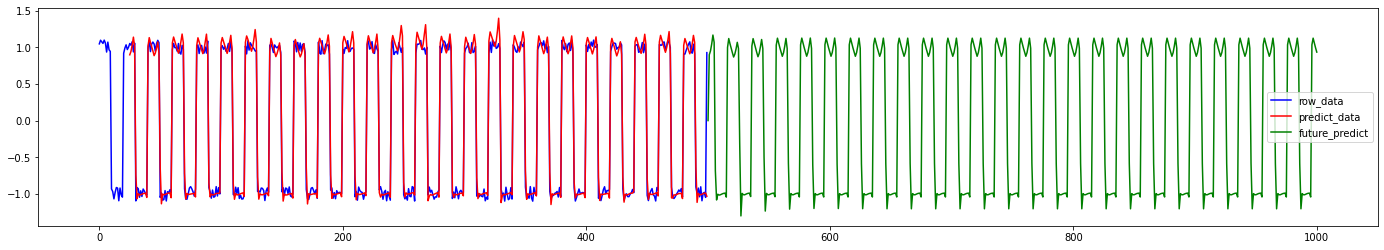

In [75]:
# test estimation
future_test = g[0] 
time_length = future_test.shape[0] # 5
future_result = np.empty((1)) # variable for store test data

for i in range(500):
    test_data = np.reshape(future_test, (1, time_length, 1))
    batch_predict = model.predict(test_data)

    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_predict)

    future_result = np.append(future_result, batch_predict)

plt.figure(figsize=(24, 4))
plt.plot(range(0, len(f)), f, color="b", label="row_data")
plt.plot(range(25, len(predicted)+25), predicted, color="r", label="predict_data")
plt.plot(range(0+len(f), len(future_result)+len(f)), future_result, color="g", label="future_predict")
plt.legend()
plt.show()